### He HUANG / LI M2/ 22107447


---

# WSD by fine-tuning a transformer-based pre-trained model

**Copy this notebook (File>Save a copy in Drive)**

**Add your name in notebook's name**

**Deadlines**
- send me a shared link by email with subject "ML3 finetuning for WSD + last NAME + NAME", before **Dec 27**
- don't forget to give me **edit rights**
- the execution traces should be visible
- **Strong advice**:
  - do the TODO1 and TODO2 by next lab session (Dec 8)
  - freeze the FlauBERT's parameters in your preliminary experiments AND check you did it right
  - don't forget to enable the use of a gpu on colab:
  - Runtime > Change runtime type > Hardware accelerator => select "T4 GPU", which is enough
  - Exécution > Modifier le type d'exécution > Accélérateur matériel > T4 GPU



We will use the French FrameNet "[ASFALDA](http://asfalda.linguist.univ-paris-diderot.fr/frameIndex.xml)" dataset to experiment the Word Sense Disambiguation task (WSD).

In this dataset, some words have been manually associated with a semantic frame:
- these words are called the **"targets"**
- find the correct frame for a given word token corresponds to a word sense disambiguation task **(WSD)**
- note though that a single frame pertains to several lexical units (e.g. FR_Commerce_buy => acheter.v, achat.n, acquérir.v, etc...)
- for this lab session, sentences containing several targets have been duplicated: each line corresponds to a (sentence, target) pair.

FrameNet data also contains annotations for the semantic roles of semantic arguments (Buyer, Seller, Goods ...), which will be ignored for this lab session.

So, the objective of this lab is to build a classifier:
- input = a (sentence, target) pair
- output = a probability distribution over the various "senses" (namely frames)
  - in basic version, we do not impose that a given target be only associated with its possible senses (namely those that were seen in the training data for this target lemma).

A central trait of our classifier will be to use the contextual representation of the target, as output by a transformer-based pre-trained language model.

Note that *BERT*-like models provide vectors for tokens, each token being potentially a subword.
**In your base version, you will use the FlauBERT vector of the FIRST token of the target word.**

Example: for the target *comprenions* in:

*Nous comprenions bien le cours*

tokenized as :

'\<s>', 'Nous\</w>', 'compren', 'ions\</w>', 'bien\</w>', 'le\</w>', 'cours\</w>', '.\</w>, '\</s>'

you will use the last hidden vector of "compren".

The base classifier will be a neural network comprising
- the pre-trained language model
- which provides the hidden vector of the 1st token of the target word
- plus a simple linear layer + softmax into the set of frames seen in the training set.

We have a single classifier for all lemmas. In the base version, we put no constraint on which frames can be associated with a given target-lemma.



In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from tqdm import tqdm
from tqdm.notebook import tqdm # for progress bars in notebooks
from random import shuffle
import os

## Naming conventions

- sentences are already segmented into words (with a rule-based tokenizer)
- but are not segmented into subwords yet
- we use "word" or "w" for the tokens obtained after pre-segmentation
- and "token" for units obtained after *BERT*-like tokenization (BPE ou WordPiece etc...)

- in variable names, we distinguish
 - integer identifiers for symbols
   (for the token vocabulary, the frame vocabulary ...)
 - versus the rank of a unit (either word or token) within a sequence
- tid => token identifier
- wrk => rank of a word in a the pre-tokenized sequence
- trk => rank of a token in a bert*-tokenized sequence
- tg => "target", so
 - tg_wrk = rank of the target word
 - tg_trk = rank of the first token of the target


## Get a variable for the device (CPU or GPU)



In [ ]:
# in order to use a GPU
# modify notebook settings:
# Runtime > Change runtime type > Hardware accelerator => select "T4 GPU", which is enough

# if a GPU is available, we will use it
if torch.cuda.is_available():
    # object torch.device
    DEVICE = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    device_id = torch.cuda.current_device()
    gpu_properties = torch.cuda.get_device_properties(device_id)
    print("We will use GPU %d (%s) of compute capability %d.%d with "
          "%.2fGb total memory.\n" %
          (device_id,
          gpu_properties.name,
          gpu_properties.major,
          gpu_properties.minor,
          gpu_properties.total_memory / 1e9))

else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")



There are 1 GPU(s) available.
We will use GPU 0 (Tesla T4) of compute capability 7.5 with 15.84Gb total memory.



In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## "ASFALDA" dataset

A French FrameNet, comprising about 16000 annotated targets, into about 100 distinct frames, along with their semantic role annotations.


### Fetching the data

In [ ]:
if not os.path.exists('./asfalda_data_for_wsd/'):
  # shell commands can be run using !
  !pip install wget
  import wget

  # The URL for the dataset zip file.
  url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/asfalda_data_for_wsd.tgz'


  if not os.path.exists('./asfalda_data_for_wsd.tgz'):
    print('Downloading dataset')
    wget.download(url, './asfalda_data_for_wsd.tgz')
    !tar zxf asfalda_data_for_wsd.tgz

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=f9b9fa143e12d7204c5a721e38524ad9ca63e761ef8e6c1aece1c0417031429d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


### Data loading method

In [ ]:
def load_asfalda_data(gold_data_file, split_info_file):
    """
        Inputs: - asfalda gold data file
                - file indicating the corpus type for each sentence id

        Returns 4 dictionaries (whose keys are corpus types (train/dev/test))
        - sentences = list of sentences, each sent is a list of words
        - list of rank of target word in each sentence
        - list of target lemmas
        - gold labels

        Example:
        sentences['train'] = [[ ]]
         # the targets are the 3rd and first words
        tg_wrks['train'] = [2, 0]
        tg_lemmas['train'] = ['comprendre', 'comprendre']
        labels['train'] = ['frame1', 'frame2']

    """
    # load the usual split into train / dev / test
    s = open(split_info_file)
    lines = [ l[:-1].split('\t') for l in s.readlines() ]
    split_info_dic = { line[0]:line[1] for line in lines }

    # dev / train / test sentences
    sentences = {'dev':[], 'train':[], 'test':[]}
    # the word ranks (wrk) for the target words
    tg_wrks = {'dev':[], 'train':[], 'test':[]}
    # target lemmas
    tg_lemmas = {'dev':[], 'train':[], 'test':[]}
    # the labels of targets (= frames)
    labels = {'dev':[], 'train':[], 'test':[]}

    max_sent_len = {'dev':0, 'train':0, 'test':0}
    max_tg_wrk = {'dev':0, 'train':0, 'test':0}

    stream = open(gold_data_file)
    for line in stream.readlines():
        if line.startswith('#'):
            continue
        line = line.strip()
        (sentid, tg_wrk, frame_name, tg_lemma, tg_pos, rest) = line.split('\t',5)
        # role annotation is ignored
        # sentences are pre-segmented into space-separated words
        # => we split on space, and will use the is_split_into_words=True mode of the FlauBERT tokenizer
        sentence = rest.split("\t")[-1].split(' ')
        part = split_info_dic[sentid]
        tg_wrk = int(tg_wrk)

        l = len(sentence)
        sentences[part].append(sentence)
        labels[part].append(frame_name)
        tg_wrks[part].append(tg_wrk)
        tg_lemmas[part].append(tg_lemma)
        if max_sent_len[part] < l:
            max_sent_len[part] = l
        if max_tg_wrk[part] < tg_wrk:
            max_tg_wrk[part] = tg_wrk
    print("Max sentence length:", max_sent_len)
    print("Max target rank (in words):", max_tg_wrk)

    return sentences, tg_wrks, tg_lemmas, labels


### Data loading and defining ids for labels

In [ ]:
gold_data_file = './asfalda_data_for_wsd/sequoiaftb.asfalda_1_3.gold.uniq.nofullant.txt'

# usual split train / dev / test for this corpus
split_info_file = './asfalda_data_for_wsd/sequoiaftb_split_info'

sentences, tg_wrks, tg_lemmas, label_strs = load_asfalda_data(gold_data_file,
                                                              split_info_file)

for p in sentences.keys():
    avgl = sum([len(s) for s in sentences[p]])/len(sentences[p])
    print("%s : %d sentences, average lentgh=%3.2f"
          %(p, len(sentences[p]), avgl))

# creating label ids for frames seen in training set
i2label = list(set(label_strs['train']))
# id for unknown frame (for dev and test)
i2label.append('*UNK*')

label2i = {x:i for i,x in enumerate(i2label)}
# id of special frame "Other_sense"
i_OTHER_SENSE = label2i['Other_sense']

# sequence of gold labels
# for each sub-corpus (key = dev/train/test)
labels = {}
for p in label_strs.keys():
    labels[p] = [label2i[x] if x in label2i else label2i['*UNK*'] for x in label_strs[p]]




Max sentence length: {'dev': 115, 'train': 271, 'test': 140}
Max target rank (in words): {'dev': 96, 'train': 267, 'test': 115}
dev : 2688 sentences, average lentgh=38.03
train : 18657 sentences, average lentgh=38.99
test : 3447 sentences, average lentgh=38.45


### TODO1 : MFS Baseline ("most frequent sense")

In WSD, a very strong baseline is to always assign the most frequent sense of a word, independently of its context.

Note this is a supervised baseline, since we need a sense-annotated corpus to compute the most frequent sense of each word.

- Compute the most frequent sense of each **target-lemma**
  (using counts found in **train**)

- and compute the MFS baseline, namely the accuracy obtained when choosing the most frequent sense of each target
  - MFS in train
  - MFS in dev (always using frequencies in train to get the most frequent senses)
    - **NB**: in case of unknown target lemma, fall back on the most frequent frame in full training data

- Study the items in dev that are unknown in train:
  - unknown target lemmas
  - unknown frame / target-lemma associations
  - unknown frames
  



In [ ]:
import pandas as pd

In [ ]:
# Create a dataframe for each sub-corpus
train_part = pd.DataFrame({'tg_lemma' : tg_lemmas['train'],
                           'label' : label_strs['train']})
dev_part = pd.DataFrame({'tg_lemma' : tg_lemmas['dev'],
                         'label' : label_strs['dev']})
test_part = pd.DataFrame({'tg_lemma' : tg_lemmas['test'],
                          'label' : label_strs['test']})

In [ ]:
# Compute the frequency of each lemma associated with each label
MSF_train = train_part.groupby(['tg_lemma', 'label']).size().reset_index(name='frequency')

In [ ]:
# Find the label with the highest frequency for each lemma in the train set
most_freq_train = MSF_train.groupby('tg_lemma').apply(lambda x: x.nlargest(1, 'frequency')).reset_index(drop=True)
most_freq_train

,tg_lemma,label,frequency
0,aborder,FR_Speak_on_topic,11
1,aboutir,Causation,24
2,aboutissement,Other_sense,4
3,accentuer,FR_Contingency-Objective_influence,7
4,acceptation,FR_Taking_sides,4
...,...,...,...
911,éviter,Preventing,49
912,évocation,FR_Speak_on_topic,1
913,évoquer,FR_Speak_on_topic,45
914,être_ce_à_dire,Other_sense,2


In [ ]:
# Select the most frequency frame in train set
most_sense_train = MSF_train['label'].value_counts().idxmax()
print("The most frequent frame in train set :", most_sense_train)

The most frequent frame in train set : Other_sense


In [ ]:
# Fall back on the most frequent frame in full training data
MSF_default = {}
dev_unknown = []

for most_lemma, most_label in zip(most_freq_train['tg_lemma'], most_freq_train['label']):
    MSF_default[most_lemma] = most_label

for dev_lemma in dev_part['tg_lemma']:
    check = MSF_default.get(dev_lemma)
    if check is None:
        dev_unknown.append(dev_lemma)
        MSF_default[dev_lemma] = most_sense_train # fall back on the most frequent frame

In [ ]:
dev_unknown # the lemmas that are not seen

['faire_ses_courses',
 'donner_son_accord',
 'déposition',
 'faire_bloc',
 'dans_cet_objectif',
 'faire_référence',
 'dénonciation',
 'prendre_le_parti',
 'se_rendre',
 'sollicitation',
 'admirer',
 'relater',
 'invalider',
 'porter_parole',
 'en_accord_avec',
 'subodorer',
 'consentement',
 'flatter',
 'fins',
 'porter_à_à']

In [ ]:
# MSF baseline in train set
train_part['MSF'] = train_part['tg_lemma'].apply(lambda x: MSF_default[x])

# Compute the accuracy
(train_part['label'] == train_part['MSF']).sum() / train_part.shape[0]

0.8139572278501367

In [ ]:
# MSF baseline in dev set
dev_part['MSF'] = dev_part['tg_lemma'].apply(lambda x: MSF_default[x])

# Compute the accuracy
(dev_part['label'] == dev_part['MSF']).sum() / dev_part.shape[0]

0.7905505952380952

In [ ]:
# Study the items in dev that are unknown in train
# 1. unknown target lemmas
dev_part[~dev_part['tg_lemma'].isin(train_part['tg_lemma'])].size

66

In [ ]:
# 2. unknown frames
dev_part[~dev_part['label'].isin(train_part['label'])].size

0

In [ ]:
# 3. unknown lemmas and frames
dev_ass = []
train_ass = []

for dev_lemma, dev_label in zip(dev_part['tg_lemma'], dev_part['label']):
   dev_ass.append((dev_lemma, dev_label))
for train_lemma, train_label in zip(train_part['tg_lemma'], train_part['label']):
   train_ass.append((train_lemma, train_label))

print("Unknown lemma with frame associations : ")

for ass_dev in dev_ass:
    if ass_dev not in train_ass:
        print(ass_dev)

Unknown lemma with frame associations : 
('délibérer', 'FR_Chatting-Discussion')
('dépenser', 'Other_sense')
('faire_ses_courses', 'Commerce_buy')
('opposition', 'Be_in_agreement_on_assessment')
('donner_son_accord', 'FR_Grant_permission-Permitting')
('déposition', 'FR_Speak_on_topic')
('convier', 'Other_sense')
('faire_bloc', 'Other_sense')
('dans_cet_objectif', 'FR_Means_for_purpose')
('confession', 'Other_sense')
('délibérer', 'FR_Chatting-Discussion')
('faire_référence', 'Other_sense')
('opposé', 'FR_Being_in_favor_of')
('dénonciation', 'Other_sense')
('plaidoirie', 'FR_Attempt_suasion.legitimacy')
('prendre_le_parti', 'FR_Deciding')
('acceptation', 'Ratification')
('se_rendre', 'Other_sense')
('sollicitation', 'Other_sense')
('admirer', 'Judgment')
('relater', 'FR_Statement-manner-noise')
('admirer', 'Judgment')
('liquider', 'Other_sense')
('invalider', 'Evidence')
('porter_parole', 'Other_sense')
('en_accord_avec', 'Be_in_agreement_on_action')
('voir', 'FR_Awareness-Certainty-Opi

## Data encoding

### FlauBERT tokenization

We use the FlauBERT model, using the Huggingface "transformers" module.

In [ ]:
try:
  import transformers
except ImportError:
  !pip install transformers

from transformers import AutoModel, AutoTokenizer, AutoConfig

# flaubert's tokenization uses as first step a tokenization into words by moses
try:
  import sacremoses
except ImportError:
  !pip install sacremoses
  import sacremoses


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.9 MB/s eta 0:00:00


In [ ]:
# We choose the FlauBERT model

# we load tokenizer and config for now
flaubert_tokenizer = AutoTokenizer.from_pretrained("flaubert/flaubert_base_cased")
flaubert_config = AutoConfig.from_pretrained("flaubert/flaubert_base_cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

### TODO2: Encoding method

The objective is to apply FlauBERT's tokenization, **keeping track of the position of the tokens of the targets**.

Follow the instructions below to fill in the encode method.

In [ ]:

class WSDEncoder:
    def __init__(self, tokenizer, config):
        self.tokenizer = tokenizer
        self.config = config # to get indices of special tokens


    # TODO
    #########################################################

    def tokenize_word(self, word):
        # Check if the word is start of an apostrophe contraction
        if word.endswith("'"):
            return self.tokenizer.encode(word[:-1], add_special_tokens=False) + \
                self.tokenizer.encode("'", add_special_tokens=False)
        else:
            # Regular tokenization
            return self.tokenizer.encode(word, add_special_tokens=False)
    #########################################################

    def encode(self, sentences, tg_wrks, max_length=100, verbose=False, is_split_into_words=True):
        """
        Input:
        - sentences : list of sentences
           -- if is_split_into_words:
              sentences are already split into words
              (hence sentences = list of word strings [[w1, w2, w3], [w1, w2]...])
           -- otherwise, sentences are to split on spaces to get words

        - tg_wrks : list of the ranks of target words
          (one rank per sentence, starting at 0 in a sentence)
        - max_length : maximum length in number of tokens

        Returns:
        - tid_seqs : the sentences padded/truncated so that each contains max_length token ids
        - first_trk_of_targets : for each sentence,
                                 the rank in corresponding tid_seq
                                 of the first token of the target word

        Example with is_split_into_words=True: a batch with one sent
        sentences = [ ['Conséquemment', ',', 'nous', 'comprendrions', '.'] ]
        tg_wrks = [3]

        if the sentence is tokenized into
        '<s>', 'Con', 'séqu', 'emment</w>', ',</w>', 'nous</w>', 'compr', 'end', 'rions</w>', '.</w>' ....
        the first token rank of the target "comprendrions" is 6 ('compr')

        """
        # TODO HERE : encoding method

        # Indications:
        # 1. apply flaubert tokenization *word per word*, and build
        #    tid_seqs first without padding / truncation nor special tokens,
        #    and keep track of token rank of first token of target word
        # 2. then truncate or pad, and add special symbols
        # (write several methods for easier reading)

        #  return tid_seqs, first_trk_of_targets

      #########################################################
        tid_seqs = []
        first_trk_of_targets = []

        for sent, tg_idx in zip(sentences, tg_wrks):
            tokenized_sent = [self.config.bos_index]
            target_lemma = sent[tg_idx]

            for i, word in enumerate(sent):
                tokenized_word = self.tokenize_word(word)
                tokenized_sent.extend(tokenized_word)

                # Check if the current word is the target word
                if i == tg_idx:
                  first_trk_of_targets.append(len(tokenized_sent) - len(tokenized_word))

            sentence_word_ids = flaubert_tokenizer(' '.join(sent),add_special_tokens=True,max_length = max_length, truncation = True,padding = "max_length",pad_to_max_length = True)['input_ids']

            tid_seqs.append(sentence_word_ids)

        return tid_seqs, first_trk_of_targets
      #########################################################

#### Encoding test

In [ ]:
encoder = WSDEncoder(flaubert_tokenizer, flaubert_config)

# test encoder
test_sents = ["Conséquemment , nous comprendrions .",
              "Le code comprend des erreurs .",
            "J' essaie de comprendre les transformers .",
            "Il n' a pas bien compris le code !"]

# we split into words (cf. asfalda dataset sentences are already split)
test_sents = [ x.split(' ') for x in test_sents ]
# target words are the occurrences of "comprendre"
test_tg_wrks = [3, 2, 3, 5]
max_length=10

# TODO: uncomment to test your encode method
tid_seqs, first_trk_of_targets = encoder.encode(test_sents, test_tg_wrks, max_length=10, verbose=True, is_split_into_words=True)

for tid_seq, ft in zip(tid_seqs, first_trk_of_targets):
    readable = flaubert_tokenizer.convert_ids_to_tokens(tid_seq)
    print("Len = %d target token rank = %d tid_seq = %s (%s)" % (len(tid_seq), ft, str(tid_seq), str(readable)))

Len = 10 target token rank = 6 tid_seq = [0, 1198, 17358, 13299, 14, 65, 18719, 1999, 19614, 1] (['<s>', 'Con', 'séqu', 'emment</w>', ',</w>', 'nous</w>', 'compr', 'end', 'rions</w>', '</s>'])
Len = 10 target token rank = 3 tid_seq = [0, 55, 1138, 976, 23, 3842, 16, 1, 2, 2] (['<s>', 'Le</w>', 'code</w>', 'comprend</w>', 'des</w>', 'erreurs</w>', '.</w>', '</s>', '<pad>', '<pad>'])
Len = 10 target token rank = 5 tid_seq = [0, 2684, 68, 5213, 15, 965, 22, 14659, 896, 1] (['<s>', 'J</w>', "'</w>", 'essaie</w>', 'de</w>', 'comprendre</w>', 'les</w>', 'transform', 'ers</w>', '</s>'])
Len = 10 target token rank = 7 tid_seq = [0, 59, 261, 68, 34, 42, 83, 681, 20, 1] (['<s>', 'Il</w>', 'n</w>', "'</w>", 'a</w>', 'pas</w>', 'bien</w>', 'compris</w>', 'le</w>', '</s>'])


### TODO3: WSDData class: full encoding and batch production

In [ ]:
import random

class WSDData:
    def __init__(self, corpus_type, sentences, tg_wrks, tg_lemmas, labels, encoder, max_length=100):
        """
        Inputs:
        - corpus type string (train/dev/test)
        - list of sentences (each sentence = list of word strings)
        - list of target word ranks : one per sentence
        - list of gold label id
        - encoder = instance of WSDEncoder

        - max_length = size of encoded sequences, in nb of bert tokens
                      (padded / truncated via encoder.encode)

        Encodes all the data using the relevant identifiers
        """

        self.corpus_type = corpus_type # train / dev / test / val
        self.size = len(sentences)
        self.encoder = encoder

        self.labels = labels       # gold label ids
        self.sentences = sentences # list of list of word strings
        self.tg_lemmas = tg_lemmas
        self.max_length = max_length

        tid_seqs, tg_trks = encoder.encode(sentences, tg_wrks, self.max_length)

        self.tid_seqs = tid_seqs  # sequences of token ids
        self.tg_trks = tg_trks    # target token ranks


    def shuffle(self):
      """
      Rearranges all the data in a new random order
      (sentences, tg_lemmas, tg_trks, tid_seqs, labels)

      NB: ** original order might be lost **
      """
      # TODO
    #########################################################
      data_zipped = list(zip(self.sentences, self.tg_lemmas, self.tg_trks, self.tid_seqs, self.labels))
      random.shuffle(data_zipped)

      return data_zipped
    #########################################################

    # production of a batch
    def make_batches(self, batch_size, device, shuffle_data=False):
        """
        Returns an iterator over 3 torch tensors
        - batch of token id sequences
        - corresponding batch of target token ranks
        - corresponding batch of labels for these targets
        """
        # TODO
        # (Tip: use "yield" function to return an iterator)

        # **NB** : the torch tensors can be directly sent to the right device
        #          using .to(device)
        # for ...
        #    ...
        #    yield(b_tid_seqs, b_tg_trks, b_labels)
      #########################################################
        if shuffle_data:
            self.shuffle()

        filtered_data = [(sent, lemma, trk, tid_seq, label)
                          for sent, lemma, trk, tid_seq, label in zip(self.sentences, self.tg_lemmas, self.tg_trks, self.tid_seqs, self.labels) if trk < self.max_length - 2]

        for i in range(0, len(filtered_data), batch_size):
          # Extract data for the current batch
          b_data = filtered_data[i:i + batch_size]

          # Prepare the batch
          b_tid_seqs = torch.tensor([d[3] for d in b_data], dtype=torch.long).to(device)
          b_tg_trks = torch.tensor([d[2] for d in b_data], dtype=torch.long).to(device)
          b_labels = torch.tensor([d[4] for d in b_data], dtype=torch.long).to(device)

          # Yield the batch
          yield (b_tid_seqs, b_tg_trks, b_labels)

      #########################################################

In [ ]:
# Encoding of the three sets train/dev/test
MAX_LENGTH = 100
wsd_data = {}
# key = part of the split corpus (train/test/dev)
for p in sentences.keys():
    print("Encoding part %s ..." % p)
    wsd_data[p] = WSDData(p, sentences[p], tg_wrks[p], tg_lemmas[p], labels[p],
                          encoder, max_length=MAX_LENGTH)
    # we check that encoding provides the right lengths
    for i, s in enumerate(wsd_data[p].tid_seqs):
        if len(s) != MAX_LENGTH:
            print("Size bug:", i, s)


Encoding part dev ...
Encoding part train ...
Encoding part test ...


In [ ]:
wsd_data['train'].sentences[0]

['Cette',
 'exposition',
 'nous',
 'apprend',
 'que',
 'dès',
 'le',
 'XIIe',
 'siècle',
 ',',
 'à',
 'Dammarie-sur-Saulx',
 ',',
 'entre',
 'autres',
 'sites',
 ',',
 'une',
 'industrie',
 'métallurgique',
 'existait',
 '.']

## WSDClassifier class: the network for WSD

Base architecture =
- the FlauBERT model
- plus linear layer + softmax

### TODO4: Digression: matrix operation

Matrix operation to fetch the bert hidden vector of the first
token of the targets.

Input is
1. x = a tensor for a batch of (truncated/padded) sentences
   containing the bert vectors for all tokens of each sentence

2. r = a tensor for the token ranks of the first token of the targets
  
=> we want to keep only the bert vectors of these first tokens

TODO: write down the shapes of tensors x and r and of the output tensor


In [ ]:
x = torch.tensor([[[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12]],
                  [[13, 14, 15, 16],
                   [17, 18, 19, 20],
                   [21, 22, 23, 24]]])
print(x.shape)
# if token ranks for the two sentences of the batch are (1,2)
r = torch.tensor([1, 2])
# => we want to get the [5, 6, 7, 8] and [21, 22, 23, 24] vectors

# write down the matrix operation
# see this source : https://discuss.pytorch.org/t/how-to-select-specific-vector-in-3d-tensor-beautifully/37724
# o = ...
o = x[torch.arange(x.size(0)), r]
print(o)
print(f"The shape of the output is {o.shape}")

torch.Size([2, 3, 4])
tensor([[ 5,  6,  7,  8],
        [21, 22, 23, 24]])
The shape of the output is torch.Size([2, 4])


### TODO5: The network : architecture, forward propagation, evaluation

In [ ]:
flaubert_model = AutoModel.from_pretrained("flaubert/flaubert_base_cased", return_dict=True)


pytorch_model.bin:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [ ]:
flaubert_model.embeddings

Embedding(68729, 768, padding_idx=2)

In [ ]:
class WSDClassifier(nn.Module):

    def __init__(self, num_labels, device, bert_model, bert_config, freeze_bert = True):
        super(WSDClassifier, self).__init__()

        self.device = device

        # the full *BERT*-like model
        # the .to(device) triggers the copy towards the relevant device
        # (possibly a GPU)
        self.bert_layer = bert_model
        # config will allow to get the hidden vectors' size
        self.bert_config = bert_config

        #########################################################
        # TODO HERE : rest of the network
        input_dim = bert_config.hidden_size

        self.linear_layer = nn.Linear(input_dim, num_labels)
        self.softmax_layer = nn.LogSoftmax(dim=1)

        # TODO: implement option to either freeze or fine-tune the BERT model
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        self.to(device)
        #########################################################

    def forward(self, b_tid_seq, b_tg_trk):
        """
        Inputs: (all are tensors, on the relevant device)
            - a batch of sentences = a batch of token id sequences
              (as output in 'input_ids' member of tokenizer output)
            - a batch of target token rank = for each of the sentences,
              the rank of first token of the target word to disambiguate

        Output: log_softmax scores for the whole batch (batch_size x num_labels)
        """
        # TODO HERE
        #  - get the *bert last hidden vectors for all the tokens of all the batch sentences
        #    [ batch_size * seq_len * bert_emb_size ]

        # Retrive only the last hidden state from BERT

        #print("b_tid_seq.device", b_tid_seq.device)
        #print("b_tid_seq.shape", b_tid_seq.shape)
        output = self.bert_layer(b_tid_seq)[0]
        #print("output.shape", output.shape)
        #  - isolate the vector of the (first) token of the target for all the batch sentences
        #    [ batch_size * bert_emb_size ]

        # Isolate the hidden state of the target token for each sentence in the batch
        tgt_hidden_state = output[torch.arange(output.size(0)), b_tg_trk.long()]
        #print("tgt_hidden_state.shape", tgt_hidden_state.shape)

        #    Tips to do this:
        #    https://discuss.pytorch.org/t/how-to-select-specific-vector-in-3d-tensor-beautifully/37724
        #
        #  - and apply linear layer
        # Pass through the classifier

        linear_out = self.linear_layer(tgt_hidden_state)
        log_softmax_scores = self.softmax_layer(linear_out)
        return log_softmax_scores

    def run_on_dataset(self, wsd_data, batch_size=32):
        """
        Run classifier on wsd_data and compute accuracy
        Inputs =
         - wsd_data (WSDDataset instance)
         - batch_size
        Returns:
         - list of predicted label ids
        """
        pred_labels = []
        gold_labels = []

        # VERY IMPORTANT : toggle evaluation mode of the model (no dropout)
        self.eval()

        # TODO
        with torch.no_grad():
            for b_tid_seqs, b_tg_trks, b_labels in wsd_data.make_batches(batch_size, self.device):

                scores = self.forward(b_tid_seqs, b_tg_trks)
                preds = scores.argmax(dim=1)
                pred_labels.append(preds)
                gold_labels.append(b_labels)

        return pred_labels, gold_labels

    def evaluate(self, gold_labels, pred_labels):
        """ returns accuracy, nb_correct, nb_total """
        # TODO
        correct = sum(gold == pred for gold, pred in zip(gold_labels, pred_labels))
        total = len(gold_labels)
        accuracy = correct / total

        return accuracy

In [ ]:
# an instance of WSDClassifier
num_labels = len(i2label)
classifier = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config)

# uncomment to see the huge nb of parameters ...
#for name, param in classifier.named_parameters():
#    print("PARAM named %s, of shape %s" % (name, str(param.shape)))
#    print(param)

#### Test of forward propagation

In [ ]:
# useless to compute gradients when testing
with torch.no_grad():
    # toggle train mode off
    classifier.eval()
    for b_tid_seqs, b_tg_trks, b_labels in wsd_data['dev'].make_batches(32, classifier.device, shuffle_data=True):

        log_probs = classifier(b_tid_seqs, b_tg_trks)
        gold = b_labels[0] #.item()
        print("GOLD LABEL of first ex %d ( = %s)" % (gold, i2label[gold]))
        print("LOG_PROBS before training: %s\n\n" % str(log_probs[0]))
        break


GOLD LABEL of first ex 11 ( = FR_Chatting-Discussion)
LOG_PROBS before training: tensor([-4.5894, -4.4675, -4.0256, -5.1313, -6.0217, -4.9460, -4.6954, -5.8852,
        -5.5249, -3.5971, -3.0743, -5.0495, -2.5728, -5.1314, -4.2159, -6.1469,
        -6.3216, -4.6064, -5.8922, -4.6553, -3.8306, -5.3917, -5.0015, -4.5284,
        -4.8239, -6.4730, -6.0997, -6.4645, -4.5307, -6.3986, -4.9323, -4.7071,
        -5.5808, -5.6732, -4.8716, -4.7578, -4.2711, -4.8957, -3.5010, -5.3068,
        -5.8354, -4.4243, -6.7641, -5.8209, -3.8994, -4.8649, -6.7769, -4.0813,
        -5.2218, -3.5869, -5.4309, -3.9486, -4.4260, -4.8575, -4.8467, -5.8450,
        -5.6314, -5.8245, -4.9561, -4.9771, -4.2732, -5.2863, -5.5016, -7.3731,
        -5.3734, -6.4758, -4.2239, -3.8969, -3.0925, -4.8087, -4.8505, -5.5460,
        -6.4659, -5.2382, -4.6858, -4.6569, -6.1225, -5.3833, -4.4674, -5.5865,
        -4.0705, -4.9271, -5.1104, -6.6564, -6.1293, -4.3895, -3.4420, -5.7738,
        -5.4490, -5.6875, -4.9133, -5.0

### TODO6: Training : fine-tuning for the WSD task

**NB** full training on train data is **LONG**, so when developping your code, first try on a small part of the data.

**NB** In general when using a *bert model in fine-tuning mode (not frozen), the needed learning rate tends to be lower

In [ ]:
def training_step(classifier, train_data, batch_size, optimizer, loss_function):
    """
    Train classifier on a batch of data

    Inputs:
     - classifier
     - train_data
     - batch_size
     - optimizer
     - loss_function

    Returns:
     - avg_train_loss
    """
    epoch_train_losses = []
    classifier.train()

    for b_tid_seqs, b_tg_trks, b_labels in train_data.make_batches(batch_size, classifier.device, shuffle_data=True):

        classifier.zero_grad()

        log_probs = classifier(b_tid_seqs, b_tg_trks)
        loss = loss_function(log_probs, b_labels)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    avg_train_loss = np.mean(epoch_train_losses)

    return avg_train_loss


In [ ]:
def validation_step(classifier, val_data, batch_size, optimizer, loss_function):
    """
    Validate classifier on a batch of data

    Inputs:
     - classifier
     - val_data
     - batch_size
     - optimizer
     - loss_function

    Returns:
     - avg_val_loss
     - accuracy
    """
    epoch_val_losses = []
    classifier.eval()

    with torch.no_grad():

        for b_tid_seqs, b_tg_trks, b_labels in val_data.make_batches(BATCH_SIZE, DEVICE):

            log_probs = classifier(b_tid_seqs, b_tg_trks)
            loss = loss_function(log_probs, b_labels)

            epoch_val_losses.append(loss.item())
            preds = log_probs.argmax(dim=1)
            accuracy = classifier.evaluate(b_labels, preds)

        avg_val_loss = np.mean(epoch_val_losses)

    return avg_val_loss, accuracy

In [ ]:
def training_loop(classifier, train_data, val_data, lr, batch_size, nb_epochs, patience, output_dir):
    """
    Train classifier on train data for nb_epochs

    Inputs:
     - classifier
     - train_data
     - val_data
     - lr
     - batch_size
     - nb_epochs
     - patience
     - output_dir

    Returns:
     - train_losses
     - val_losses
    """

    loss_function = nn.NLLLoss(reduction='mean')
    # SGD is quicker (more convenient for debug phase)
    #optimizer = optim.SGD(classifier.parameters(), lr=LR)
    optimizer = optim.Adam(classifier.parameters(), lr=LR)

    # losses at each epoch (on train / on validation set)
    train_losses = []
    val_losses = []
    val_acc = []
    min_val_loss = None

    epoch_id = 0

    # Early stopping
    patience_counter = 0

    while epoch_id < nb_epochs:
        # train
        train_loss = training_step(classifier, train_data, batch_size, optimizer, loss_function)
        train_losses.append(train_loss)

        # validate
        val_loss, accuracy = validation_step(classifier, val_data, batch_size, optimizer, loss_function)
        val_losses.append(val_loss)
        val_acc.append(accuracy)

        print("Epoch %d: train loss = %0.4f, val loss = %0.4f, val acc = %0.4f" % (epoch_id, train_loss, val_loss, accuracy))

        # Early stopping
        if min_val_loss is None or val_loss < min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch_id}")
                break

        epoch_id += 1

    return train_losses, val_losses, val_acc


In [ ]:
num_labels = len(label2i)
classifier = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config)

BATCH_SIZE = 32
LR = 0.0005
NB_EPOCHS = 20
PATIENCE = 2

config_name = 'sequoiaftb.asfalda_1_3.wsd.lr' + 'Adam' + str(LR) + '_bs' + str(BATCH_SIZE)
out_model_file = './' + config_name + '.model'
out_log_file = './' + config_name + '.log'


# to speed up during debug: train on dev
#train_data = wsd_data['dev'] # data['train']
train_data = wsd_data['train']
val_data = wsd_data['dev']
test_data = wsd_data['test']

train_losses, val_losses, val_acc = training_loop(classifier, train_data, val_data, LR, BATCH_SIZE, NB_EPOCHS, PATIENCE, out_model_file) # train_losses, val_losses
print("train losses: %s" % ' / '.join([ "%.4f" % x for x in train_losses]))
print("val   losses: %s" % ' / '.join([ "%.4f" % x for x in val_losses]))
print("val   acc: %s" % ' / '.join([ "%.4f" % x for x in val_acc]))

Epoch 0: train loss = 1.6249, val loss = 0.8076, val acc = 0.8214
Epoch 1: train loss = 0.8164, val loss = 0.6323, val acc = 0.8571
Epoch 2: train loss = 0.6740, val loss = 0.5743, val acc = 0.8214
Epoch 3: train loss = 0.6175, val loss = 0.5559, val acc = 0.8571
Epoch 4: train loss = 0.5926, val loss = 0.5432, val acc = 0.8571
Epoch 5: train loss = 0.5582, val loss = 0.5310, val acc = 0.8571
Epoch 6: train loss = 0.5448, val loss = 0.5415, val acc = 0.8571
Epoch 7: train loss = 0.5184, val loss = 0.5396, val acc = 0.8571
Early stopping at epoch 7
train losses: 1.6249 / 0.8164 / 0.6740 / 0.6175 / 0.5926 / 0.5582 / 0.5448 / 0.5184
val   losses: 0.8076 / 0.6323 / 0.5743 / 0.5559 / 0.5432 / 0.5310 / 0.5415 / 0.5396
val   acc: 0.8214 / 0.8571 / 0.8214 / 0.8571 / 0.8571 / 0.8571 / 0.8571 / 0.8571


In [ ]:
# Hyperparameters search
batch_size = [32, 64, 128]
lr = [0.00005, 0.001, 0.005]

accuracy_list = []
hyperparameters_list = []

for b in batch_size:
  for l in lr:
    hyperparameters_list.append((b, l))
    print("Batch size: %d, LR: %f" % (b, l))
    classifier = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config)
    train_losses, val_losses, val_acc = training_loop(classifier, train_data, val_data, l, b, NB_EPOCHS, PATIENCE, out_model_file) # train_losses, val_losses

    max_accuracy = max(val_acc)
    accuracy_list.append(max_accuracy)


best_accuracy = max(accuracy_list)
best_hyperparameters = hyperparameters_list[accuracy_list.index(best_accuracy)]
print("Best hyperparameters: %s, accuracy: %0.4f" % (best_hyperparameters, best_accuracy))

Batch size: 32, LR: 0.000050
Epoch 0: train loss = 1.6387, val loss = 0.8217, val acc = 0.8571
Epoch 1: train loss = 0.8157, val loss = 0.6232, val acc = 0.8214
Epoch 2: train loss = 0.6842, val loss = 0.5726, val acc = 0.8571
Epoch 3: train loss = 0.6222, val loss = 0.5455, val acc = 0.8214
Epoch 4: train loss = 0.5793, val loss = 0.5287, val acc = 0.8571
Epoch 5: train loss = 0.5614, val loss = 0.5180, val acc = 0.8571
Epoch 6: train loss = 0.5337, val loss = 0.5230, val acc = 0.8571
Epoch 7: train loss = 0.5288, val loss = 0.5111, val acc = 0.8571
Epoch 8: train loss = 0.5077, val loss = 0.5086, val acc = 0.8214
Epoch 9: train loss = 0.5139, val loss = 0.5163, val acc = 0.8929
Epoch 10: train loss = 0.4910, val loss = 0.5186, val acc = 0.8929
Early stopping at epoch 10
Batch size: 32, LR: 0.001000
Epoch 0: train loss = 1.6334, val loss = 0.7871, val acc = 0.9286
Epoch 1: train loss = 0.8188, val loss = 0.6256, val acc = 0.8214
Epoch 2: train loss = 0.6752, val loss = 0.5646, val acc

In [ ]:
best_classifier = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config)
train_losses, val_losses, val_acc = training_loop(best_classifier, train_data, val_data, 0.001, 32, NB_EPOCHS, PATIENCE, out_model_file) # train_losses, val_losses

Epoch 0: train loss = 1.6184, val loss = 0.8179, val acc = 0.8929
Epoch 1: train loss = 0.8055, val loss = 0.6178, val acc = 0.8571
Epoch 2: train loss = 0.6815, val loss = 0.5719, val acc = 0.8571
Epoch 3: train loss = 0.6198, val loss = 0.5364, val acc = 0.8214
Epoch 4: train loss = 0.5788, val loss = 0.5238, val acc = 0.8571
Epoch 5: train loss = 0.5560, val loss = 0.5326, val acc = 0.8214
Epoch 6: train loss = 0.5336, val loss = 0.5229, val acc = 0.8571
Epoch 7: train loss = 0.5243, val loss = 0.5104, val acc = 0.8571
Epoch 8: train loss = 0.5174, val loss = 0.5187, val acc = 0.8214
Epoch 9: train loss = 0.5124, val loss = 0.5163, val acc = 0.8214
Early stopping at epoch 9


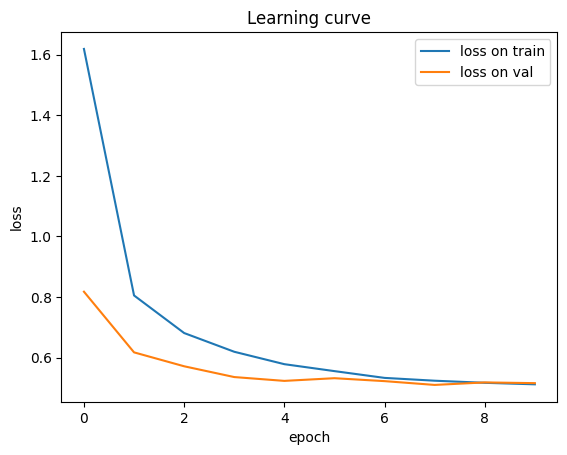

In [ ]:
# Graph to visualize losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='loss on train')
plt.plot(val_losses, label='loss on val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve')
plt.legend()
plt.show()

### TODO7: Evaluation

In [ ]:
# TODO HERE : run on dev and evaluate

best_classifier.eval()
pred_labels, gold_labels = best_classifier.run_on_dataset(test_data, batch_size=32)

accuracy = 0

for gold, pred in zip(gold_labels, pred_labels):
    accuracy += best_classifier.evaluate(gold, pred)

avg_accuracy = accuracy / len(gold_labels)

print(f"Accuracy on the test set: {avg_accuracy:.4f} in frozen mode.")

Accuracy on the test set: 0.8415 in frozen mode.


In [ ]:
# Hyperparameters search in fine-tuning
batch_size = [32, 64, 128]
lr = [0.00005, 0.001, 0.005]

accuracy_list = []
hyperparameters_list = []

for b in batch_size:
  for l in lr:
    hyperparameters_list.append((b, l))
    print("Batch size: %d, LR: %f" % (b, l))
    classifier = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config, freeze_bert = False)
    train_losses, val_losses, val_acc = training_loop(classifier, train_data, val_data, l, b, NB_EPOCHS, PATIENCE, out_model_file) # train_losses, val_losses

    max_accuracy = max(val_acc)
    accuracy_list.append(max_accuracy)


best_accuracy_ft = max(accuracy_list)
best_hyperparameters_ft = hyperparameters_list[accuracy_list.index(best_accuracy_ft)]
print("Best hyperparameters : %s, Best accuracy : %0.4f" % (best_hyperparameters_ft, best_accuracy_ft))

In [ ]:
# Run on dev and evaluate in fine-tuning mode

best_classifier_ft = WSDClassifier(num_labels, DEVICE, flaubert_model, flaubert_config, freeze_bert = False)
train_losses, val_losses, val_acc = training_loop(best_classifier_ft, train_data, val_data, 0.001, 128, NB_EPOCHS, PATIENCE, out_model_file) # train_losses, val_losses

Epoch 0: train loss = 2.3253, val loss = 1.1468, val acc = 0.8214
Epoch 1: train loss = 1.1223, val loss = 0.7643, val acc = 0.8571
Epoch 2: train loss = 0.8667, val loss = 0.6533, val acc = 0.8214
Epoch 3: train loss = 0.7539, val loss = 0.5964, val acc = 0.8571
Epoch 4: train loss = 0.6878, val loss = 0.5656, val acc = 0.8571
Epoch 5: train loss = 0.6426, val loss = 0.5380, val acc = 0.8571
Epoch 6: train loss = 0.5989, val loss = 0.5280, val acc = 0.8929
Epoch 7: train loss = 0.5765, val loss = 0.5191, val acc = 0.8571
Epoch 8: train loss = 0.5655, val loss = 0.5157, val acc = 0.8571
Epoch 9: train loss = 0.5470, val loss = 0.5034, val acc = 0.8214
Epoch 10: train loss = 0.5268, val loss = 0.5000, val acc = 0.8571
Epoch 11: train loss = 0.5193, val loss = 0.4984, val acc = 0.8571
Epoch 12: train loss = 0.5068, val loss = 0.4905, val acc = 0.8929
Epoch 13: train loss = 0.5032, val loss = 0.4835, val acc = 0.8929
Epoch 14: train loss = 0.4954, val loss = 0.4887, val acc = 0.8571
Epoch

In [ ]:
best_classifier_ft.eval()
pred_labels, gold_labels = best_classifier_ft.run_on_dataset(test_data, batch_size=32)

accuracy = 0

for gold, pred in zip(gold_labels, pred_labels):
    accuracy += best_classifier_ft.evaluate(gold, pred)

avg_accuracy = accuracy / len(gold_labels)

print(f"Accuracy on the test set: {avg_accuracy:.4f} in fine-tuning mode.")

Accuracy on the test set: 0.8496 in fine-tuning mode.


## Scale ("barème")

- basic system will give 12 points

- quality of code / comments = 2 points


- various additional points (to choose)

  - generalization analysis
   Do you think it would be better to predict seen-in-train lemma/frame associations only ?
   (in order to answer that question, propose and implement simple analysis of the predictions performed without any control of the frame/lemma association)

  - implement an option to only predict seen-in-train lemma/frame associations

  - nice hyperparameter search

  - high results thanks to nice hyperparameter search

  - implement early stopping

  - does it help to fine-tune with a MLP instead of single layer ?

  - does it help to use a concatenation of flaubert's embeddings at different layers instead of the last layer only (eg 4 last layers, cf. table 7 of devlin et al. 2019) (do this in frozen mode only)

  - does it help to add a lemma embedding of the target (concatenate it to the bert output, before final linear layer)?

  - ... other ideas are welcome ...

Approximate expected accuracy:
 - In frozen mode, basic system can reach 83 / 84 % on the dev set when well trained

 - In fine-tuning mode: results seem unstable
  - take care to search for an appropriate learning rate, which tends to be lower than in frozen mode
  - some of the runs get stuck at 37% of accuracy, corresponding to assigning the MFS to all the instances ("other_sense" frame)
  - when learning goes well, accuracy can reach 88, or even 90% for some runs


NB: write below what you chose to investigate / implement.
Summarize your results / hyper-parameter search.
For an extra feature to count, you need to write down an analysis of the results.

Your notebook should show traces of a complete training and evaluation phase.

### Conclusion



I've implemented early stopping in the `training_loop` function of the training loop, if the validation loss does not improve for 2 epochs, the training is stopped. And it seems to work well for the frozen model and the fine-tuned model.  

Also, i've done the hyperparameter search in both modes. For the frozen mode, the learning rate is set to 0.001 and the batch size is set to 32. For the fine-tuning mode, the learning rate is set to the same value as in the frozen mode and the batch size is set to 128.

Finally, from the graph and the results of evaluation, i've found that the fine-tuning mode is slightly better than the frozen mode. But both of them can reach 84% on the test set.

\#@@ very good